<a href="https://colab.research.google.com/github/BYK82/AIFFEL/blob/main/%5BE_15%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 15-9. 프로젝트 - Movielens 영화 추천 실습

이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

  - 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
  - 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
  - 별점을 시청횟수로 해석해서 생각하겠습니다.
  - 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.


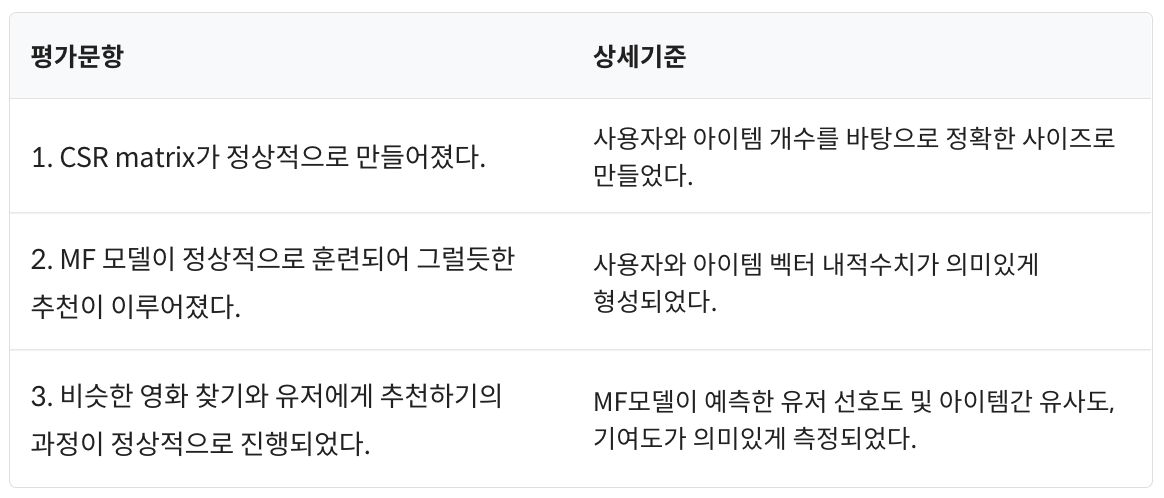

In [1]:
%%capture
!pip install implicit

In [2]:
import matplotlib.pyplot as plt   
import math   
import time   
from datetime import datetime   
import pandas as pd   
import numpy as np
import pandas as pd
import os

import scipy
import implicit
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장 사항
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) 데이터 준비와 전처리

In [4]:
# 파일 불러오기
ratings_file_path = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 15/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# rating 컬럼의 이름을 counts로 변경
ratings.rename(columns={'rating':'counts'}, inplace=True)
ratings

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [6]:
# 사용하는 컬럼 재정의
using_cols = ['user_id', 'movie_id', 'counts']
ratings = ratings[using_cols]
ratings.head(10)

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [7]:
# 메타데이터 확인
movie_file_path = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 15/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding = 'ISO-8859-1')
movies.head(10)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


## 2) 분석해 봅시다.

  - ratings에 있는 유니크한 영화 개수
  - ratings에 있는 유니크한 사용자 수
  - 가장 인기 있는 영화 30개(인기순)

In [8]:
# ratings에 있는 유니크한 영화 개수
ratings['movie_id'].nunique()

3706

In [9]:
# ratings에 있는 유니크한 사용자 수
ratings['user_id'].nunique()

6040

In [10]:
# 가장 인기 있는 영화 30개(인기순)
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_top30 = movie_count.sort_values(ascending=False).head(30)

In [11]:
# 30개의 영화 누적 count수
for i, k in zip(movie_top30.index, movie_top30.values):
    print(movies[movies['movie_id']==i]['title'].values[0],k)

American Beauty (1999) 3428
Star Wars: Episode IV - A New Hope (1977) 2991
Star Wars: Episode V - The Empire Strikes Back (1980) 2990
Star Wars: Episode VI - Return of the Jedi (1983) 2883
Jurassic Park (1993) 2672
Saving Private Ryan (1998) 2653
Terminator 2: Judgment Day (1991) 2649
Matrix, The (1999) 2590
Back to the Future (1985) 2583
Silence of the Lambs, The (1991) 2578
Men in Black (1997) 2538
Raiders of the Lost Ark (1981) 2514
Fargo (1996) 2513
Sixth Sense, The (1999) 2459
Braveheart (1995) 2443
Shakespeare in Love (1998) 2369
Princess Bride, The (1987) 2318
Schindler's List (1993) 2304
L.A. Confidential (1997) 2288
Groundhog Day (1993) 2278
E.T. the Extra-Terrestrial (1982) 2269
Star Wars: Episode I - The Phantom Menace (1999) 2250
Being John Malkovich (1999) 2241
Shawshank Redemption, The (1994) 2227
Godfather, The (1972) 2223
Forrest Gump (1994) 2194
Ghostbusters (1984) 2181
Pulp Fiction (1994) 2171
Terminator, The (1984) 2098
Toy Story (1995) 2077


## 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [12]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite_name = ['Home Alone 2: Lost in New York (1992)' , 'Home Alone 3 (1997)' ,'Home Alone (1990)','Lion King, The (1994)','Toy Story (1995)']
my_favorite = [movies[movies['title'] == name]['movie_id'].values[0] for name in my_favorite_name]

# my(맨끝에 추가되는 id)이라는 user_id가 위 영화를 5회씩 봤다고 가정하겠습니다.
my = max(ratings['user_id']) + 1
my_playlist = pd.DataFrame({'user_id': [my]*5, 'movie_id': my_favorite, 'counts':[5]*5})

if not ratings.isin({'user_id':[my]})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    ratings = ratings.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 
ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,6041,2953,5
1,6041,1707,5
2,6041,586,5
3,6041,364,5
4,6041,1,5


## 4) CSR matrix를 직접 만들어 봅시다.

In [13]:
# 실습 위에 설명보고 이해해서 만들어보기

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
print(num_user, num_movie)

# csr_data 생성
csr_data = csr_matrix((ratings['counts'], (ratings['user_id'], ratings['movie_id'])))
csr_data 


6041 3706


<6042x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 1000214 stored elements in Compressed Sparse Row format>

## 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [14]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [15]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [16]:
als_model = AlternatingLeastSquares(
    factors=512,   #user 및 movie vector 차원
    regularization=0.01,   #정규화 값
    use_gpu=False,   #GPU 사용 여부
    iterations=30,   #epochs
    dtype=np.float32
)


In [17]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.longlong'>'
	with 1000214 stored elements in Compressed Sparse Column format>

In [18]:
# 모델 훈련
als_model.fit(csr_data)

  0%|          | 0/30 [00:00<?, ?it/s]

## 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [19]:
# 영화의 이름을 movie id로 바꿔주는 함수
def movie_name_to_id(name):
    return movies[movies['title']==name]['movie_id'].values[0]

In [20]:
len(als_model.user_factors)

6042

In [21]:
my_vector, home_vector = als_model.user_factors[6041], als_model.item_factors[movie_name_to_id('Home Alone 3 (1997)')]
other_vector = als_model.item_factors[movie_name_to_id('American Beauty (1999)')]

In [22]:
print("user - Home alone 3:", round(np.dot(my_vector, home_vector), 3))
print("user - American Beauty:", round(np.dot(my_vector, other_vector), 3))

user - Home alone 3: 0.364
user - American Beauty: -0.008


In [23]:
def score_movie(movie_name):
    my_vector, movie_vector = als_model.user_factors[6041], als_model.item_factors[movie_name_to_id(movie_name)]
    return np.dot(my_vector, movie_vector)

In [24]:
for i in movie_top30.index:
    tmp = movies[movies['movie_id']==i]['title'].values[0]
    print(tmp," :",  score_movie(tmp))

American Beauty (1999)  : -0.007651292
Star Wars: Episode IV - A New Hope (1977)  : 0.020104993
Star Wars: Episode V - The Empire Strikes Back (1980)  : 0.015600955
Star Wars: Episode VI - Return of the Jedi (1983)  : -0.0036715046
Jurassic Park (1993)  : -0.004579095
Saving Private Ryan (1998)  : 0.009556277
Terminator 2: Judgment Day (1991)  : 0.033362404
Matrix, The (1999)  : -0.022494648
Back to the Future (1985)  : 0.010393247
Silence of the Lambs, The (1991)  : -0.034770228
Men in Black (1997)  : -0.03382908
Raiders of the Lost Ark (1981)  : -0.027664255
Fargo (1996)  : -0.054084897
Sixth Sense, The (1999)  : -0.0637238
Braveheart (1995)  : -0.0039866064
Shakespeare in Love (1998)  : -0.019284727
Princess Bride, The (1987)  : 0.0066091567
Schindler's List (1993)  : -0.0015523285
L.A. Confidential (1997)  : -0.042148504
Groundhog Day (1993)  : 0.09726547
E.T. the Extra-Terrestrial (1982)  : -0.025871767
Star Wars: Episode I - The Phantom Menace (1999)  : 0.030360911
Being John Mal

## 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [25]:
favorite_movie = 'Home Alone 2: Lost in New York (1992)'
movie_id = movie_name_to_id(favorite_movie)
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

(array([2953, 1707,  355, 2798, 2799, 2042,  374,   87, 1474,  575, 1822,
        2449,  310,  419, 2223], dtype=int32),
 array([1.0000001 , 0.71716946, 0.6590477 , 0.6443831 , 0.633258  ,
        0.61206084, 0.59908545, 0.5862424 , 0.58276975, 0.5790444 ,
        0.577404  , 0.57586455, 0.57582426, 0.57567567, 0.5724028 ],
       dtype=float32))

In [26]:
sim_movie = []
for i, j in zip(similar_movie[0],similar_movie[1]):
  sim_movie.append((i,j))
sim_movie

[(2953, 1.0000001),
 (1707, 0.71716946),
 (355, 0.6590477),
 (2798, 0.6443831),
 (2799, 0.633258),
 (2042, 0.61206084),
 (374, 0.59908545),
 (87, 0.5862424),
 (1474, 0.58276975),
 (575, 0.5790444),
 (1822, 0.577404),
 (2449, 0.57586455),
 (310, 0.57582426),
 (419, 0.57567567),
 (2223, 0.5724028)]

In [27]:
for i, k in sim_movie:
    print(movies[movies['movie_id']==i]['title'].values[0],' :', k)

Home Alone 2: Lost in New York (1992)  : 1.0000001
Home Alone 3 (1997)  : 0.71716946
Flintstones, The (1994)  : 0.6590477
Problem Child (1990)  : 0.6443831
Problem Child 2 (1991)  : 0.633258
D2: The Mighty Ducks (1994)  : 0.61206084
Richie Rich (1994)  : 0.59908545
Dunston Checks In (1996)  : 0.5862424
Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)  : 0.58276975
Little Rascals, The (1994)  : 0.5790444
Meet the Deedles (1998)  : 0.577404
Garbage Pail Kids Movie, The (1987)  : 0.57586455
Rent-a-Kid (1995)  : 0.57582426
Beverly Hillbillies, The (1993)  : 0.57567567
Farmer's Wife, The (1928)  : 0.5724028


In [28]:
movies[movies['movie_id'].isin([s[0] for s in sim_movie])][['title','genre']]

,title,genre
86,Dunston Checks In (1996),Children's|Comedy
307,Rent-a-Kid (1995),Comedy
351,"Flintstones, The (1994)",Children's|Comedy
370,Richie Rich (1994),Children's|Comedy
415,"Beverly Hillbillies, The (1993)",Comedy
571,"Little Rascals, The (1994)",Children's|Comedy
1446,Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997),Children's|Comedy
1659,Home Alone 3 (1997),Children's|Comedy
1756,Meet the Deedles (1998),Children's|Comedy
1973,D2: The Mighty Ducks (1994),Children's|Comedy


## 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.


In [35]:
user = 6041
movie_recommended = als_model.recommend(user, csr_data, N=25, filter_already_liked_items=False)
movie_recommended

(array([   1,  364,  586, 2953, 1707,  595, 2082,  588,  355, 2053, 2042,
           2,  370, 1588,  348, 3179,  455, 3578, 1013, 2798, 2139, 2424,
         575, 1474,   48], dtype=int32),
 array([0.9500282 , 0.7703785 , 0.74885553, 0.5694762 , 0.36389214,
        0.2576836 , 0.24871233, 0.21498282, 0.20477667, 0.16175416,
        0.16110778, 0.1538847 , 0.1503897 , 0.14857227, 0.14078681,
        0.1403049 , 0.13943928, 0.13856015, 0.1382789 , 0.1347419 ,
        0.13363126, 0.13240556, 0.13182864, 0.13114882, 0.13091335],
       dtype=float32))

In [36]:
recom_movie = []
for i, j in zip(movie_recommended[0],movie_recommended[1]):
  recom_movie.append((i,j))
recom_movie

[(1, 0.9500282),
 (364, 0.7703785),
 (586, 0.74885553),
 (2953, 0.5694762),
 (1707, 0.36389214),
 (595, 0.2576836),
 (2082, 0.24871233),
 (588, 0.21498282),
 (355, 0.20477667),
 (2053, 0.16175416),
 (2042, 0.16110778),
 (2, 0.1538847),
 (370, 0.1503897),
 (1588, 0.14857227),
 (348, 0.14078681),
 (3179, 0.1403049),
 (455, 0.13943928),
 (3578, 0.13856015),
 (1013, 0.1382789),
 (2798, 0.1347419),
 (2139, 0.13363126),
 (2424, 0.13240556),
 (575, 0.13182864),
 (1474, 0.13114882),
 (48, 0.13091335)]

In [37]:
# 좋아할만한 영화와 수치 장르 확인
for i, k in recom_movie:
    print(movies[movies['movie_id']==i]['title'].values[0],' :',k)

Toy Story (1995)  : 0.9500282
Lion King, The (1994)  : 0.7703785
Home Alone (1990)  : 0.74885553
Home Alone 2: Lost in New York (1992)  : 0.5694762
Home Alone 3 (1997)  : 0.36389214
Beauty and the Beast (1991)  : 0.2576836
Mighty Ducks, The (1992)  : 0.24871233
Aladdin (1992)  : 0.21498282
Flintstones, The (1994)  : 0.20477667
Honey, I Blew Up the Kid (1992)  : 0.16175416
D2: The Mighty Ducks (1994)  : 0.16110778
Jumanji (1995)  : 0.1538847
Naked Gun 33 1/3: The Final Insult (1994)  : 0.1503897
George of the Jungle (1997)  : 0.14857227
Bullets Over Broadway (1994)  : 0.14078681
Angela's Ashes (1999)  : 0.1403049
Free Willy (1993)  : 0.13943928
Gladiator (2000)  : 0.13856015
Parent Trap, The (1961)  : 0.1382789
Problem Child (1990)  : 0.1347419
Secret of NIMH, The (1982)  : 0.13363126
You've Got Mail (1998)  : 0.13240556
Little Rascals, The (1994)  : 0.13182864
Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)  : 0.13114882
Pocahontas (1995)  : 0.13091335


In [38]:
movies[movies['movie_id'].isin([m[0] for m in recom_movie])][['title','genre']]


,title,genre
0,Toy Story (1995),Animation|Children's|Comedy
1,Jumanji (1995),Adventure|Children's|Fantasy
47,Pocahontas (1995),Animation|Children's|Musical|Romance
344,Bullets Over Broadway (1994),Comedy
351,"Flintstones, The (1994)",Children's|Comedy
360,"Lion King, The (1994)",Animation|Children's|Musical
366,Naked Gun 33 1/3: The Final Insult (1994),Comedy
451,Free Willy (1993),Adventure|Children's|Drama
571,"Little Rascals, The (1994)",Children's|Comedy
582,Home Alone (1990),Children's|Comedy


## 회고

- 추천 시스템은 처음 하는 거라서 지난 몇번의 노드와 비슷하게 깃헙과 구글과 조원분들의 도움을 받아서 ctrl+c,v 의 역할이 컸다. 문제는 왜인지 모르겠지만 거의 비슷하게 복붙을 했는데 als.model 에 csr data를 transpose 한 후에 넣은 것들은 User와 item이 바껴서 나오는 것이었다. 참고한 레퍼런스들에서는 모델에서 user와 item이 바껴서 들어가기때문에 입력할때 transpose를 한다고 적혀있었지만 내가 실행했을 때는 transpose 한 데이터를 넣었을 때 transpose되서 결과가 나왔다. 첨엔 복붙이라 어디가 틀린줄 알고 여러번 반복했는데.. 다르게 나오는대로 다시 코드를 짜서 실행해보니 분석 결과는 transpose를 시키지 않고 넣은 것이 제대로 나오는 것으로 확인되었다. (내가 선택한 영화들이 추천 목록 상위에 높은 점수로 그대로 나오는것을 확인함) 결국은 버전이 다른게 아닌가...

- 노드와 참고한 레퍼런스에서는 데이터 전처리로 평점 3점 이하는 지웠는데 굳이 그럴 필요성을 못느껴서 그대로 진행했다. (3을 제외하고도 해봤는데 결과는 같은 조건에서 빼지 않았을 때 유사도가 더 높게 나오는 것을 확인했다. 

- 학습차원을 100에서 512로 늘리고 에폭을 10->30->100으로 바꿔가면서 진행했는데 예상과 다르게 100일때보다 30일때 나홀로집에와 my벡터의 유사도가 더 높게 잡혔다. 에폭이 높다고 무조건 추천을 잘하는 것은 아닌 것 같다.

- 역시나 혼자서 하라고 하면 1도 이해하지 못했지만, 추천을 이렇게 해주는구나는 알게된 노드인것같다. 
